# Lending Club Loan Analysis

## Business Objectives
This company is the largest online loan marketplace, facilitating personal loans, business loans, and financing of medical procedures. Borrowers can easily access lower interest rate loans through a fast online interface. 

 

Like most other lending companies, lending loans to ‘risky’ applicants is the largest source of financial loss (called credit loss). The credit loss is the amount of money lost by the lender when the borrower refuses to pay or runs away with the money owed. In other words, borrowers who default cause the largest amount of loss to the lenders. In this case, the customers labelled as 'charged-off' are the 'defaulters'. 

 

If one is able to identify these risky loan applicants, then such loans can be reduced thereby cutting down the amount of credit loss. Identification of such applicants using EDA is the aim of this case study.

 

In other words, the company wants to understand the driving factors (or driver variables) behind loan default, i.e. the variables which are strong indicators of default.  The company can utilise this knowledge for its portfolio and risk assessment. 

In [1]:
# Import lib. for data analysis
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')


from scipy.stats import ttest_ind


In [2]:
loan = pd.read_csv('./loan.csv')

# Data Cleaning

### 1. Remove columns with missing values

In [3]:
# delete column having 80% of missing values
missing_columns = loan.columns[loan.isnull().sum()/len(loan.index)*100 > 80]
print(missing_columns)

Index(['mths_since_last_record', 'next_pymnt_d', 'mths_since_last_major_derog',
       'annual_inc_joint', 'dti_joint', 'verification_status_joint',
       'tot_coll_amt', 'tot_cur_bal', 'open_acc_6m', 'open_il_6m',
       'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il',
       'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util',
       'total_rev_hi_lim', 'inq_fi', 'total_cu_tl', 'inq_last_12m',
       'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util',
       'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op',
       'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc',
       'mths_since_recent_bc_dlq', 'mths_since_recent_inq',
       'mths_since_recent_revol_delinq', 'num_accts_ever_120_pd',
       'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl',
       'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0',
       'num_sats', 'num_tl_120dpd_2m', 'num_tl_30dpd', 'num_tl_90g_dpd_24m',
 

In [4]:
# Dropping all the columns with null values
loan = loan.drop(missing_columns, axis=1)
print(loan.shape)

(39717, 55)


In [5]:
# All urls are unique. Not required for the analysis. Dropping this column
print(loan['url'].head())
loan = loan.drop('url', axis=1)

0    https://lendingclub.com/browse/loanDetail.acti...
1    https://lendingclub.com/browse/loanDetail.acti...
2    https://lendingclub.com/browse/loanDetail.acti...
3    https://lendingclub.com/browse/loanDetail.acti...
4    https://lendingclub.com/browse/loanDetail.acti...
Name: url, dtype: object


In [6]:
# It is string var. Does not seem like it can be used untill key words can be extracted. 
print(loan['desc'].head())
loan = loan.drop('desc', axis=1)

0      Borrower added on 12/22/11 > I need to upgra...
1      Borrower added on 12/22/11 > I plan to use t...
2                                                  NaN
3      Borrower added on 12/21/11 > to pay for prop...
4      Borrower added on 12/21/11 > I plan on combi...
Name: desc, dtype: object


In [7]:
# Removing these columns as they have single value
print(loan['initial_list_status'].unique())
print(loan['collections_12_mths_ex_med'].unique())
print(loan['policy_code'].unique())
print(loan['application_type'].unique())
print(loan['acc_now_delinq'].unique())
print(loan['chargeoff_within_12_mths'].unique())
print(loan['delinq_amnt'].unique())
print(loan['tax_liens'].unique())
print(loan['pymnt_plan'].unique())

loan = loan.drop(['initial_list_status',
                  'collections_12_mths_ex_med',
                  'policy_code',
                  'application_type',
                  'acc_now_delinq',
                  'chargeoff_within_12_mths',
                  'delinq_amnt',
                  'tax_liens',
                  'pymnt_plan'], axis=1)

['f']
[ 0. nan]
[1]
['INDIVIDUAL']
[0]
[ 0. nan]
[0]
[ 0. nan]
['n']


In [8]:
# Removing member_id column
loan = loan.drop('member_id', axis=1)

In [9]:
loan.shape

(39717, 43)

### 2. Convert non-numeric ordinal data to numeric

In [10]:
# Convert term column to int
print(loan['term'].unique())
loan['term'] = loan['term'].apply(lambda x : 36 if x==' 36 months' else 60)
print(loan['term'].unique())

[' 36 months' ' 60 months']
[36 60]


In [11]:
# convert int_rate to float
print(loan['int_rate'].head(2))
loan['int_rate'] = loan['int_rate'].apply(lambda x : float(x[0:-1]))
print(loan['int_rate'].head(2))

0    10.65%
1    15.27%
Name: int_rate, dtype: object
0    10.65
1    15.27
Name: int_rate, dtype: float64


In [12]:
# Convert emp_length to int
loan['emp_length'].unique()
emp_replace_dict = {'10+ years':10, '< 1 year':0, '1 year':1, 
                    '3 years':3, '8 years':8, '9 years':9,'4 years':4,
                    '5 years':5, '6 years':6, '2 years':2, '7 years':7}

loan['emp_length'].replace(emp_replace_dict, inplace=True)
loan['emp_length'].head()

0    10.0
1     0.0
2    10.0
3    10.0
4     1.0
Name: emp_length, dtype: float64

In [13]:
# Convert revol_util into int
loan['revol_util'] = loan['revol_util'].replace(np.nan, '', regex=True)
loan['revol_util'] = loan['revol_util'].apply(lambda x : float(x[0:-1]) if len(x) > 0 else np.nan )

In [14]:
# One hot encoding for loan status
loan_status_dummies = pd.get_dummies(loan['loan_status'])
print(loan_status_dummies.head())

loan = pd.concat([loan, loan_status_dummies], axis=1)

   Charged Off  Current  Fully Paid
0            0        0           1
1            1        0           0
2            0        0           1
3            0        0           1
4            0        1           0


# Bivariate Analysis

## 1. Numerical Data Correlation

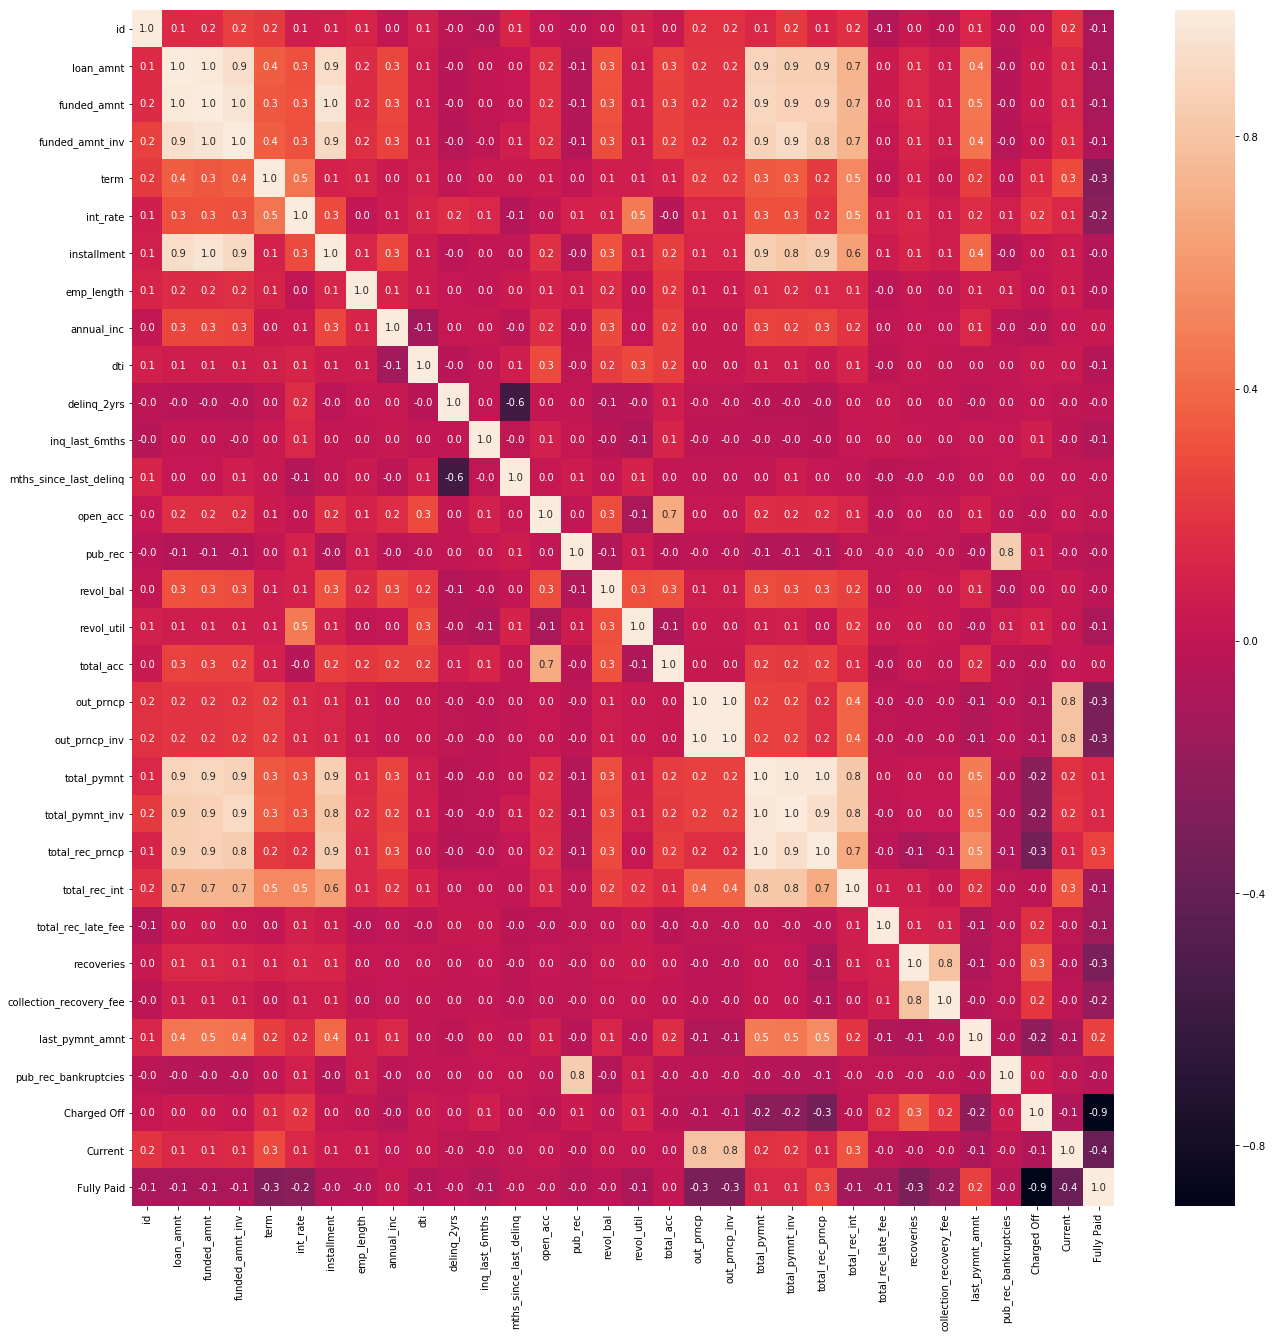

In [15]:
# Analyze correlation between numeric data types
numerics = ['uint8','int16', 'int32', 'int64', 'float16', 'float32', 'float64']
loan_numeric = loan.select_dtypes(include=numerics)
corr = loan_numeric.corr()

# Plot the heat map
fig, ax = plt.subplots(figsize=(22,22))       
sns.heatmap(corr, 
            xticklabels=corr.columns,
            yticklabels=corr.columns,
            fmt=".1f",
            annot=True,
            ax = ax)

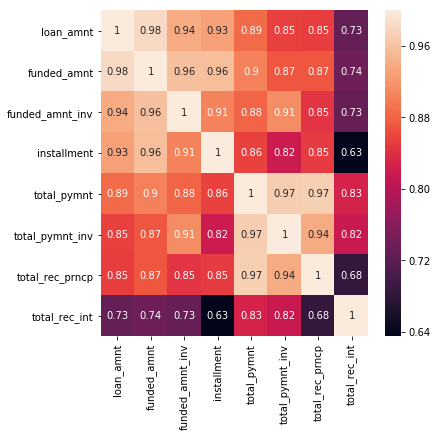

In [16]:
# We conclude from above heapmap that these columns have positive correlation.
# 1. loan_amt
# 2. funded_amnt
# 3. funded_amnt_inv
# 4. installment
# 5. total_pymnt
# 6. total_pymnt_inv
# 7. total_rec_prncp
# 8. total_rec_int

corr = loan_numeric.loc[:, ['loan_amnt', 'funded_amnt', 'funded_amnt_inv',
             'installment', 'total_pymnt', 'total_pymnt_inv',
             'total_rec_prncp', 'total_rec_int']].corr()

fig, ax = plt.subplots(figsize=(6,6))       

sns.heatmap(corr, 
            xticklabels=corr.columns,
            yticklabels=corr.columns,
            annot=True,
            ax = ax)

In [17]:
# out_prncp and out_prncp_inv have corr value. They are related.
print(loan_numeric['out_prncp'].corr(loan_numeric['out_prncp_inv']))

0.9998274655132868


In [18]:
# pub_rec and pub_rec_bankruptcies have corr value. They are related.
loan_numeric['pub_rec'].corr(loan_numeric['pub_rec_bankruptcies'])

0.8473050197507596

In [19]:
# recoveries and collection_recovery_fee have corr value. They are related.
loan_numeric['recoveries'].corr(loan_numeric['collection_recovery_fee'])

0.7968162787436553

In [20]:
# delinq_2yrs and mths_since_last_delinq have negative corr value. They are related.
loan_numeric['delinq_2yrs'].corr(loan['mths_since_last_delinq'])

-0.5694377632564083

### Conclusion
In the above heat map we found out the correlation between various features. But any **strong** correlation between **Charged Off** and other features **could not be found out**. We need to dig deeper.

## 2. Finding the relation of features with defaulters using plots

In [21]:
# Remove the 'Current' loan status as it is not relevant in the current context
loan_subset_df = loan.loc[loan['loan_status'] != 'Current']


In [22]:
# Helper function to draw plots for numerical data
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

def showPlots(tips, colname, scale, lq, rq, title):
    tips_copy = tips.loc[(tips.loc[:, colname] > 0) & 
                         (tips.loc[:,colname] <= tips.loc[:, colname].quantile(rq)) &
                         (tips.loc[:,colname] >= tips.loc[:, colname].quantile(lq))]
        
    if scale == "log":
        tips_copy.loc[:, colname] = np.log(tips_copy.loc[:, colname])
    fig, axs = plt.subplots(ncols=2, figsize=(20, 6))
    ax1 = sns.distplot(tips_copy[colname], ax=axs[0]);
    ax1.set(xlabel=title, ylabel='Fraction', title=title + " distribution")
    ax2=sns.boxplot(x="loan_status", y=colname, data=tips_copy, ax=axs[1])
    ax2.set(xlabel="Loan Status", ylabel=title, title=title + " v/s Loan Status")
    
def showNumericalPlots(**kwargs):  
    showPlots(kwargs['data'],
              kwargs['colname'],
              kwargs['scale'],
              kwargs['left_quantile'],
              kwargs['right_quantile'],
              kwargs['title']
             )
    
def compareLoanStatus(data, colname):
    print(color.BLUE + color.BOLD + 'Charged Off data' + color.END)
    print(data.loc[data['loan_status'] == 'Charged Off'][colname].describe())
    print('')
    print(color.RED + color.BOLD + 'Fully paid data' + color.END)
    print(data.loc[data['loan_status'] == 'Fully Paid'][colname].describe())
    
def performTTest(data, colname):
    print('')
    print(color.GREEN + color.BOLD + 't-score' + color.END)
    print(ttest_ind(data.loc[data['loan_status'] == 'Charged Off'][colname], 
          data.loc[data['loan_status'] == 'Fully Paid'][colname]))

In [23]:
# Helper function to draw plots for categorical data
def showCategoricalPlots(tips, colname, width, xlabel):
    tips_copy = tips.groupby([colname, 'loan_status'])[colname].count().unstack()
    tips_copy['Charged Off %'] = (tips_copy['Charged Off'] / (tips_copy['Charged Off'] + tips_copy['Fully Paid'])) * 100
    tips_copy.sort_values(by="Charged Off %", ascending=False, inplace=True)
    plot = tips_copy.loc[:, ['Charged Off %']].plot.bar(figsize=(width, 4))
    plot.set(xlabel=xlabel, ylabel="Charged Off %", title=xlabel + " v/s Loan Status")
    plot.spines['top'].set_visible(False)
    plot.spines['right'].set_visible(False)
    print(tips_copy.head(10))
    
# Helper function to draw plots for categorical data
def showCategoricalPlotsStacked(tips, colname, width, xlabel):
    tips_copy = tips.groupby([colname, 'loan_status'])[colname].count().unstack().reset_index()
    tips_copy['Fully Paid %'] = (tips_copy['Fully Paid'] / (tips_copy['Charged Off'] + tips_copy['Fully Paid'])) * 100
    tips_copy['Charged Off %'] = (tips_copy['Charged Off'] / (tips_copy['Charged Off'] + tips_copy['Fully Paid'])) * 100
    tips_copy.sort_values(by="Charged Off %", ascending=False, inplace=True)
    ax = tips_copy.loc[:, [colname, 'Fully Paid %', 'Charged Off %']].set_index(colname).plot(kind='bar', stacked=True, figsize=(width, 4))
    ax.set(xlabel=xlabel, ylabel='Loan Status %', title=xlabel + " v/s Loan Status")
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    print(tips_copy.loc[:,[colname, 'Charged Off', 'Fully Paid',  'Charged Off %']].set_index(colname).head(10))


### 2.1 Numerical data v/s Loan status

### 2.1.1 int_rate
**Desc : Interest Rate on the loan**

Charged Off data
count    5627.000000
mean       13.820432
std         3.654413
min         5.420000
25%        11.310000
50%        13.610000
75%        16.400000
max        24.400000
Name: int_rate, dtype: float64

Fully paid data
count    32950.000000
mean        11.609761
std          3.599964
min          5.420000
25%          8.490000
50%         11.490000
75%         13.990000
max         24.110000
Name: int_rate, dtype: float64

t-score
Ttest_indResult(statistic=42.47806088833117, pvalue=0.0)


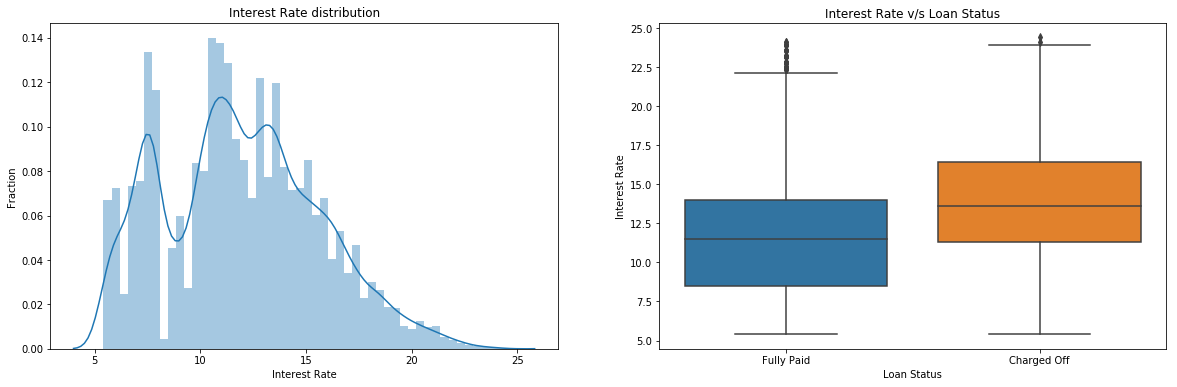

In [24]:
# Draw dist plot for int_rate and compare the boxplot for Fully paid and Charged off
showNumericalPlots(data=loan_subset_df,
                   colname='int_rate',
                   left_quantile=0.0,
                   right_quantile=1.0,
                   scale='linear',
                   title='Interest Rate')


# Hypothesis : The int_rate variable has higher median for charged_off loan status
compareLoanStatus(loan_subset_df, 'int_rate')

# median [charged off] = 13.61%
# median [fully paid] = 11.49%

performTTest(loan_subset_df, 'int_rate')

# t-score = 42.48
# Large t-score confirms that the int_rate for defaulters [Fully Paid] and 
# non-defaulters [Charged Off] are different.

# Inference :  In int_rate is higher, then probability of default is higher.


### 2.1.2 annual_inc
**Desc : The self-reported annual income provided by the borrower during registration.**

Charged Off data
count    5.627000e+03
mean     6.242730e+04
std      4.777601e+04
min      4.080000e+03
25%      3.700000e+04
50%      5.300000e+04
75%      7.500000e+04
max      1.250000e+06
Name: annual_inc, dtype: float64

Fully paid data
count    3.295000e+04
mean     6.986250e+04
std      6.656225e+04
min      4.000000e+03
25%      4.113275e+04
50%      6.000000e+04
75%      8.400000e+04
max      6.000000e+06
Name: annual_inc, dtype: float64


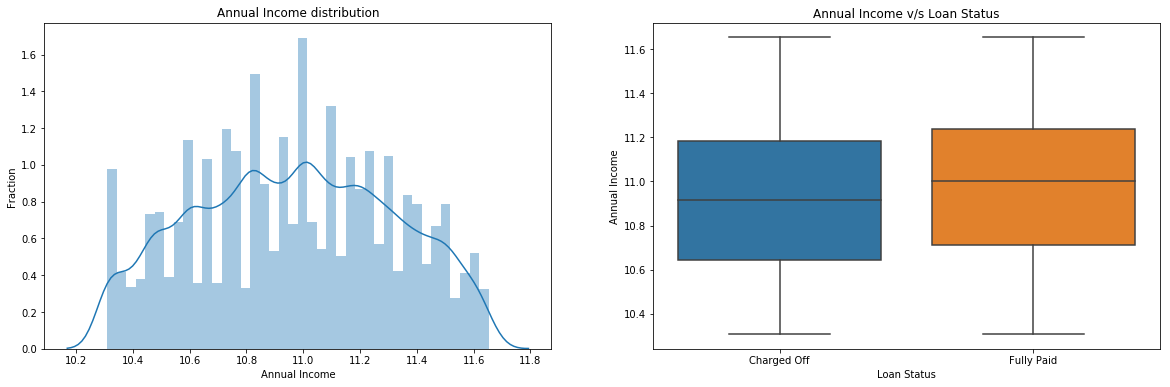

In [25]:
# Draw dist plot for annual_inc and compare the boxplot for Fully paid and Charged off
# Remove outlier and scale to log
showNumericalPlots(data=loan_subset_df,
                   colname='annual_inc',
                   left_quantile=0.1,
                   right_quantile=0.9,
                   scale='log',
                   title='Annual Income')

# Hypothesis : The annual_inc variable has higher median for charged_off loan status
compareLoanStatus(loan_subset_df, 'annual_inc')

# median [charged off] = $53,000
# median [fully paid] = $60,000

# Inference :  If annual_inc is lower, then probability of default is higher.



### 2.1.3 total_rec_late_fee
**Desc : Late fees received to date**

loan_status
Charged Off    3.157632
Fully Paid     0.680276
Name: total_rec_late_fee, dtype: float64
(775, 46)
(450, 46)
(1052, 46)
(907, 46)


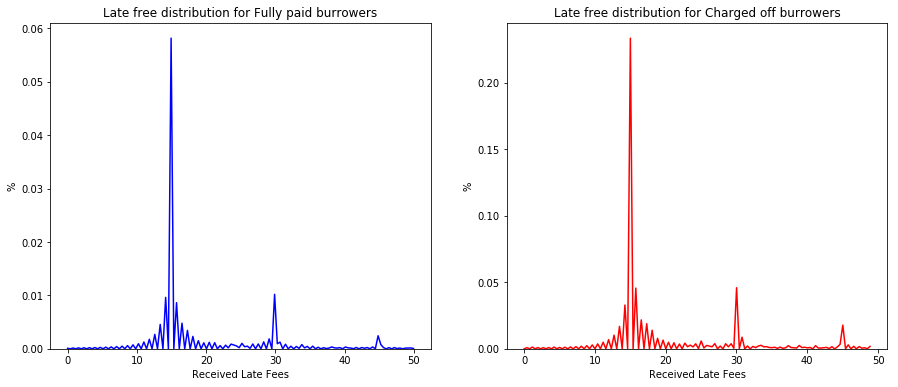

In [26]:
# Calculate mean of total_rec_late_fee  
# Remove outliers whose fees > $50
loan_subset_df_late_fee = loan_subset_df.loc[(loan_subset_df['total_rec_late_fee'] < 50)]
print(loan_subset_df_late_fee.groupby(['loan_status'])['total_rec_late_fee'].mean())

fig, axs = plt.subplots(ncols=2, figsize=(15, 6))

ax0 = sns.distplot(loan_subset_df_late_fee.loc[loan_subset_df_late_fee['loan_status'] == 'Fully Paid']['total_rec_late_fee'],
             ax=axs[0],
             color="blue",
             hist=False);
ax0.set(xlabel='Received Late Fees', ylabel='%', title='Late free distribution for Fully paid burrowers')

ax1 = sns.distplot(loan_subset_df_late_fee.loc[loan_subset_df_late_fee['loan_status'] == 'Charged Off']['total_rec_late_fee'],
             ax=axs[1], 
             color='red',
             hist=False);

ax1.set(xlabel='Received Late Fees', ylabel='%', title='Late free distribution for Charged off burrowers')


# Calclate number of defaulters with fees > $0
print(loan_subset_df.loc[(loan_subset_df['total_rec_late_fee'] > 0) & 
                   (loan_subset_df_late_fee['loan_status'] == 'Charged Off')].shape)

# Calclate number of defaulters with fees >= $15
print(loan_subset_df.loc[(loan_subset_df['total_rec_late_fee'] >= 15) & 
                   (loan_subset_df_late_fee['loan_status'] == 'Charged Off')].shape)

# Calclate number of non-defaulters with fees > $0
print(loan_subset_df.loc[(loan_subset_df['total_rec_late_fee'] > 0) & 
                   (loan_subset_df_late_fee['loan_status'] == 'Fully Paid')].shape)

# Calclate number of non-defaulters with fees >= $15
print(loan_subset_df.loc[(loan_subset_df['total_rec_late_fee'] >= 15) & 
                   (loan_subset_df_late_fee['loan_status'] == 'Fully Paid')].shape)


# Observation :  The mean total late fee recieved for fully paid burrowers is sigficantly less that those
#                who were charged off. 
#
#                1. In the below graph, atleast 23% of defaulters have paid $15 or more while only 6%
#                   non-defaulters have paid $15.
#                2. Mean for Charged Off is $3.15 while mean for Fully Paid is $0.68.
#                3. There are 13% Defaulters with late fees > $0 in comparison to 3% such non-defaulters.
#                4. There are 9% defaulters with late fess > $15 in comarison to 2.5% such non-defaulters.

# Inference   : Those who have high late fee sum (>= $15) will have high rate of default.


### 2.1.4 loan_amnt v/s total_pymnt
**Desc : Comparison of Loan amount and the Total payment made till now**

loan_status
Charged Off    10000
Fully Paid      9600
Name: loan_amnt, dtype: int64
loan_status
Charged Off     4839.00000
Fully Paid     10687.15722
Name: total_pymnt, dtype: float64


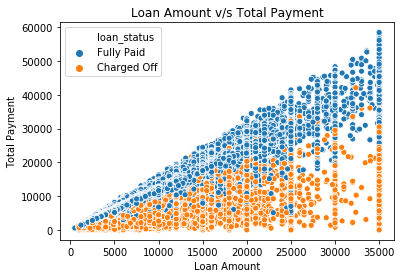

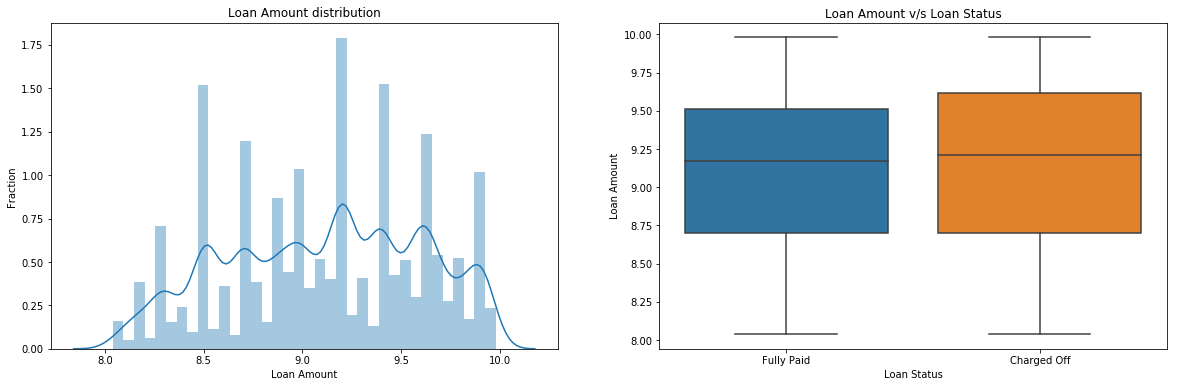

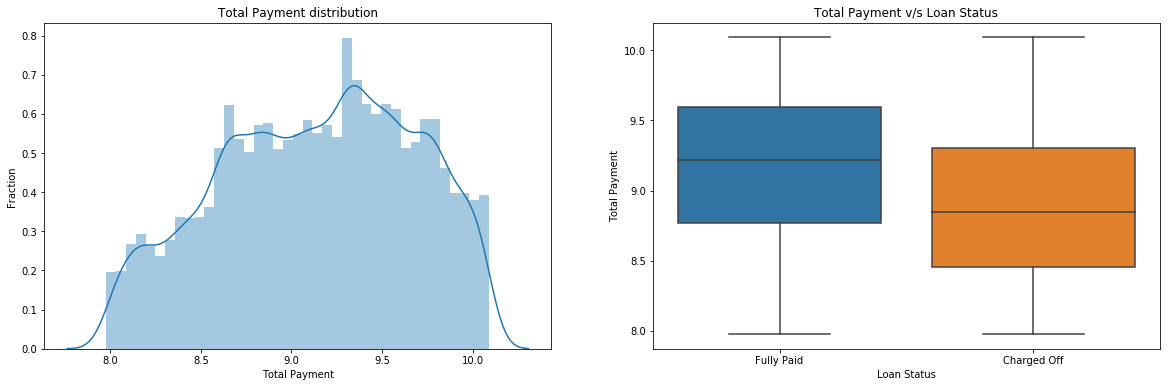

In [27]:
# Scatter plot between loan_amnt and total_pymnt
ax = sns.scatterplot(x="loan_amnt", 
                y="total_pymnt",
                data=loan_subset_df,
                hue='loan_status')

ax.set(xlabel='Loan Amount', ylabel='Total Payment', title='Loan Amount v/s Total Payment')

# Draw dist plot for loan_amnt and compare the boxplot for Fully paid and Charged off
# Remove outlier and scale to log
showNumericalPlots(data=loan_subset_df,
                   colname='loan_amnt',
                   left_quantile=0.1,
                   right_quantile=0.9,
                   scale='log',
                   title='Loan Amount')

# Draw dist plot for total_pymnt and compare the boxplot for Fully paid and Charged off
# Remove outlier and scale to log
showNumericalPlots(data=loan_subset_df,
                   colname='total_pymnt',
                   left_quantile=0.1,
                   right_quantile=0.9,
                   scale='log',
                   title='Total Payment')

# Calculate median
print(loan_subset_df.groupby(['loan_status'])['loan_amnt'].median())
print(loan_subset_df.groupby(['loan_status'])['total_pymnt'].median())


# Observation :  The mean total payment recieved for charged paid burrowers is sigficantly less that those
#                whofully paid. 
#
#                1. In the below scatter plot, despite having same loan amount, the total payment for
#                   the defaulters is lesser than the non-defaulters.
#                2. The median for loan_amnt is almost same for Charged Off ($9,600) and Fully Paid ($10,000) but 
#                   total_pymnt median for Charged Off is only $4842 compared to $10687 for Fully Paid

# Inference   : Those who have less total_pymnt for the same loan_amnt will have high possibility of being
#               Charged Off.


### 2.1.5 total_rec_prncp
**Desc : Principle received to date**

loan_status
Charged Off    2729.59
Fully Paid     9200.00
Name: total_rec_prncp, dtype: float64


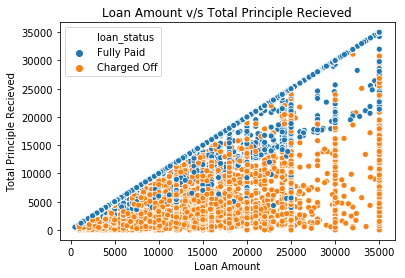

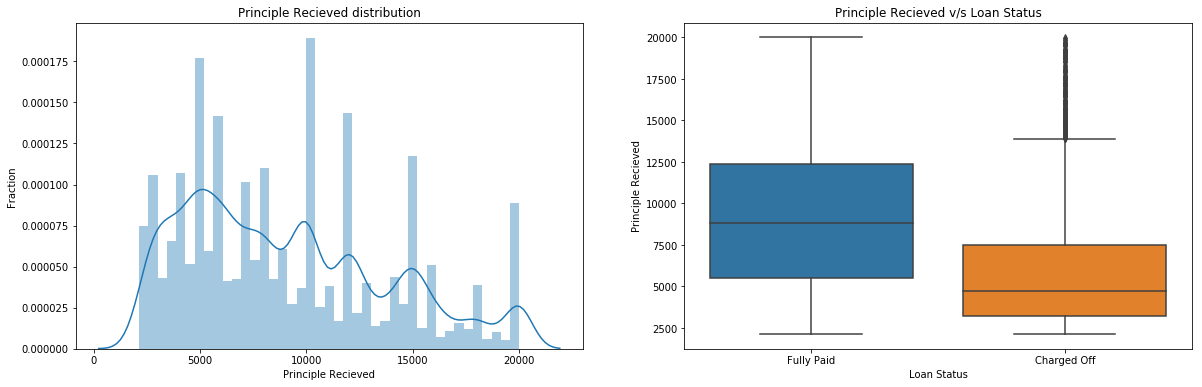

In [28]:
# Scatter plot between loan_amnt and total_rec_prncp
ax = sns.scatterplot(y="total_rec_prncp", 
                     x="loan_amnt",
                     data=loan_subset_df,
                     hue='loan_status')

ax.set(xlabel='Loan Amount', ylabel='Total Principle Recieved', title='Loan Amount v/s Total Principle Recieved')

# Draw dist plot for total_rec_prncp and compare the boxplot for Fully paid and Charged off
# Remove outlier and scale to log
showNumericalPlots(data=loan_subset_df,
                   colname='total_rec_prncp',
                   left_quantile=0.1,
                   right_quantile=0.9,
                   scale='linear',
                   title='Principle Recieved')

# Calculate median
print(loan_subset_df.groupby(['loan_status'])['total_rec_prncp'].median())

# median [charged off] = $2,730
# median [fully paid] = $9,200

# Observation :  The median total principle recieved for charged paid burrowers is sigficantly less that those
#                whofully paid. 
#
#                1. In the below scatter plot, despite having same loan amount, the total principle recieved
#                   from the defaulters is lesser than the non-defaulters.
#                2. The median for loan_amnt is almost same for Charged Off ($9,600) and Fully Paid ($10,000) but 
#                   total_rec_prncp median for Charged Off is only $2730 compared to $9200 for Fully Paid

# Inference :  Those who have less total_rec_prncp for the same loan_amnt will have high possibility of being
#              Charged Off.

### 2.2 Categorical data v/s Loan status

### 2.2.1 last_paymnt_d
**Desc : Last month payment was received**

loan_status        Charged Off  Fully Paid  Charged Off %
last_pymnt_d_year                                        
09                         228         331      40.787120
08                          45          92      32.846715
10                         513        1335      27.759740
11                        1036        3960      20.736589
12                        1682        7222      18.890386
13                        1219        8239      12.888560
15                         218        2213       8.967503
14                         601        8668       6.483979
16                          14         890       1.548673


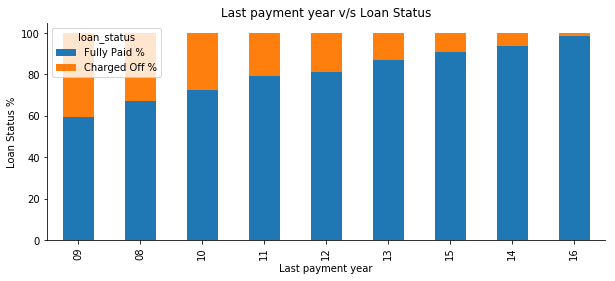

In [29]:
# Create a derived column last_pymnt_d_year
loan_subset_df.loc[:, 'last_pymnt_d'] = loan_subset_df['last_pymnt_d'].replace(np.nan, '', regex=True)
loan_subset_df.loc[:, 'last_pymnt_d_year'] = loan_subset_df['last_pymnt_d'].apply(lambda x : (x[-2:]) if len(x) > 0 else np.nan )
showCategoricalPlotsStacked(loan_subset_df, 'last_pymnt_d_year', 10, 'Last payment year')

# Observation : The Charged off % is higher as the last payment date are earlier.
# Inference :   If the last payment date of a loan is older, then there is a high probability
#               that it will be charged off.


### 2.2.2 verification_status
**Desc : Indicates if income was verified by LC, not verified, or if the income source was verified**

loan_status          Charged Off  Fully Paid  Charged Off %
verification_status                                        
Verified                    2051       10155      16.803212
Source Verified             1434        8243      14.818642
Not Verified                2142       14552      12.830957


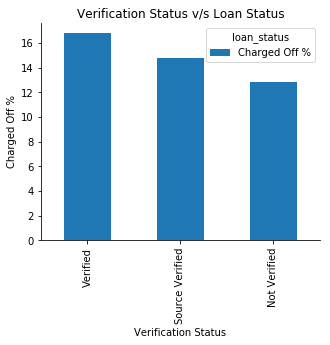

In [30]:
showCategoricalPlots(loan_subset_df, 'verification_status', 5, 'Verification Status')

# Observation : The Charged off % is higher if the customer is Verified by LC.
# Inference :   If the customer is Verified, the probability of him defaulting is high.


### 2.2.3 purpose
**Desc : A category provided by the borrower for the loan request.**

loan_status         Charged Off  Fully Paid  Charged Off %
purpose                                                   
small_business              475        1279      27.080958
renewable_energy             19          83      18.627451
educational                  56         269      17.230769
other                       633        3232      16.377749
house                        59         308      16.076294
moving                       92         484      15.972222
medical                     106         575      15.565345
debt_consolidation         2767       15288      15.325395
vacation                     53         322      14.133333
home_improvement            347        2528      12.069565


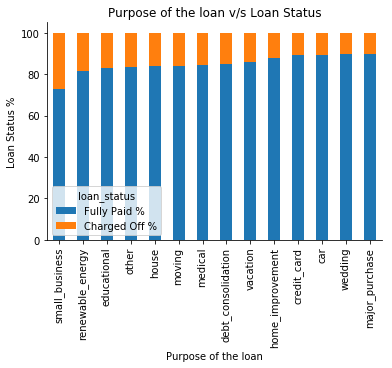

In [31]:
plot_df = showCategoricalPlotsStacked(loan_subset_df, 'purpose', 6, 'Purpose of the loan')

# Observation : The Charged off % is dependent on the purpose of the loan. There is a significantly high 
#               default rate for small_business
# Inference :   If the burrower is taking the loan for Small Business, then changes of default are high 
#               than any other purpose.


### 2.2.4 addr_state
**Desc : The state provided by the borrower in the loan application**

loan_status  Charged Off  Fully Paid  Charged Off %
addr_state                                         
NV                 108.0       371.0      22.546973
SD                  12.0        50.0      19.354839
AK                  15.0        63.0      19.230769
FL                 504.0      2277.0      18.122977
MO                 114.0       556.0      17.014925
HI                  28.0       138.0      16.867470
ID                   1.0         5.0      16.666667
NM                  30.0       153.0      16.393443
OR                  71.0       364.0      16.321839
CA                1125.0      5824.0      16.189380


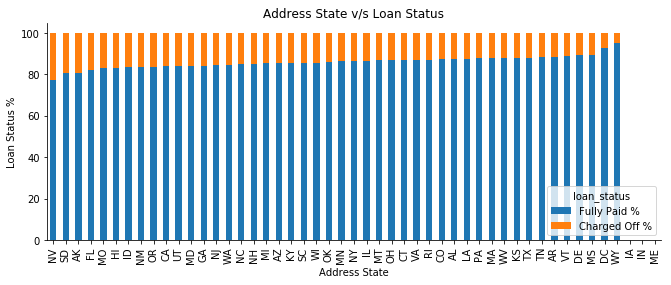

In [32]:
# Removing NE state (outlier) due to it's unusual high % of Charged Off.
loan_subset_df = loan_subset_df.loc[loan_subset_df['addr_state'] != 'NE']
showCategoricalPlotsStacked(loan_subset_df, 'addr_state', 11, 'Address State')

# Observation : The Charged off % is also dependent on the state of the burrower. There is a high 
#               default rate for NV state.
# Inference :   If the burrower is taking the loan belongs to NV the he has 22% change of defaulting.


# 3. Univariate Analysis

#### Objective:-  To find which burrower is more likely to default

## 3.1 loan_status analysis
**Desc : Current status of the loan** 

loan_status
Charged Off     5627
Current         1140
Fully Paid     32950
Name: loan_status, dtype: int64


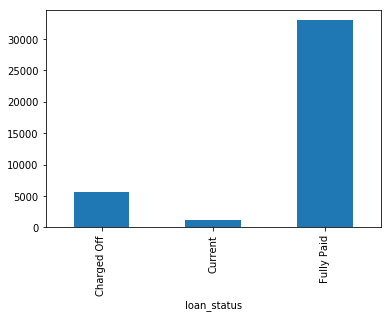

In [33]:
df_grp = loan.groupby('loan_status')['loan_status'].count()
print(df_grp)

# Charged off (default) % = 14.60

df_grp.plot.bar()

## 3.2 Segmented Univariate analysis

### 3.2.1 Segmenting loan_status by `grade and sub_grade`

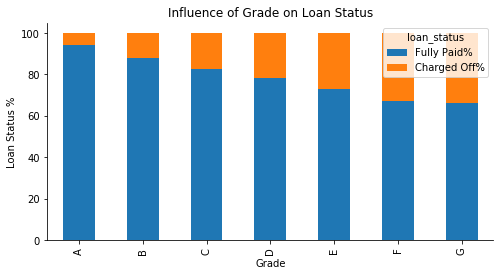

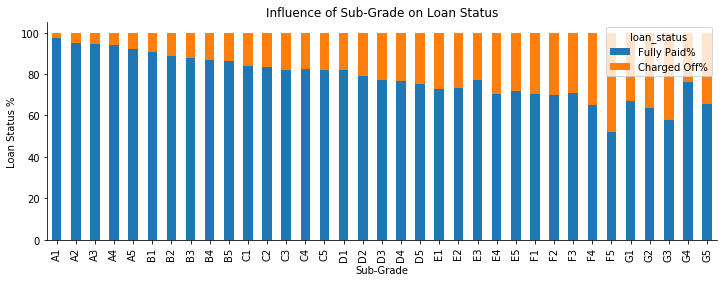

In [34]:
# Analyse grade and sub_grade vs loan_status

df_grp = loan_subset_df.groupby(['grade', 'loan_status'])['loan_status'].count().unstack().reset_index('grade')
df_grp['Charged Off%'] = df_grp['Charged Off'] / (df_grp['Charged Off'] + df_grp['Fully Paid']) * 100
df_grp['Fully Paid%'] = df_grp['Fully Paid'] / (df_grp['Charged Off'] + df_grp['Fully Paid']) * 100
ax1 = df_grp.loc[:, ['grade', 'Fully Paid%', 'Charged Off%']].set_index('grade').plot(kind='bar', stacked=True, figsize=(8, 4))
ax1.set(xlabel='Grade', ylabel='Loan Status %', title='Influence of Grade on Loan Status')
ax1.patch.set_facecolor('white')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

df_grp = loan_subset_df.groupby(['sub_grade', 'loan_status'])['loan_status'].count().unstack().reset_index('sub_grade')
df_grp['Charged Off%'] = df_grp['Charged Off'] / (df_grp['Charged Off'] + df_grp['Fully Paid']) * 100
df_grp['Fully Paid%'] = df_grp['Fully Paid'] / (df_grp['Charged Off'] + df_grp['Fully Paid']) * 100
ax2 = df_grp.loc[:, ['sub_grade', 'Fully Paid%', 'Charged Off%']].set_index('sub_grade').plot(kind='bar', stacked=True, figsize=(12, 4))
ax2.set(xlabel='Sub-Grade', ylabel='Loan Status %', title='Influence of Sub-Grade on Loan Status')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

# Observation : The Charged off % is also dependent on the grade and sub-grade of the burrower. There is a high 
#               default rate if grade or sub_grade are lower.
#               Grade: Here A is better than B better than C and so on
#               Sub-grade: Here A1 is better than A2 better than A3 and so on.

# Inference :   If the burrower is taking the loan belongs to the lower grade then he has high change of defaulting.


### 3.2.2 Segmenting loan_status by `term`

loan_status  Charged Off  Fully Paid  Charged Off %
term                                               
60                  2400        7081      25.313785
36                  3224       25867      11.082465


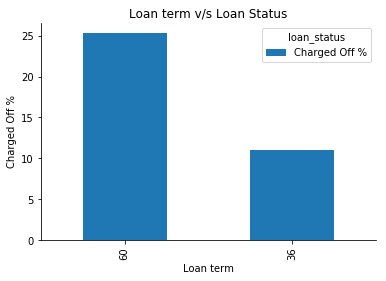

In [35]:
showCategoricalPlots(loan_subset_df, 'term', 6, 'Loan term')

# Observation : The Charged off % is also dependent on the term. There is a high 
#               default rate if term is 60.

# Inference :   If the burrower is taking the loan for 60 months, there is 25% chance of defaulting.


### 3.2.3 Segmenting loan_status by `emp_length`

loan_status  Charged Off  Fully Paid  Charged Off %
emp_length                                         
10.0                1331        7156      15.682809
7.0                  263        1448      15.371128
1.0                  455        2713      14.362374
5.0                  458        2735      14.343877
6.0                  307        1861      14.160517
8.0                  203        1232      14.146341
0.0                  637        3869      14.136707
3.0                  555        3457      13.833500
4.0                  462        2880      13.824057
2.0                  567        3724      13.213703


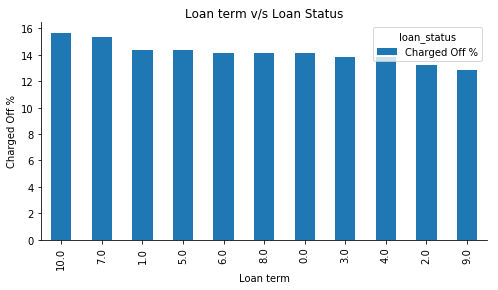

In [36]:
showCategoricalPlots(loan_subset_df, 'emp_length', 8, 'Loan term')

# Observation : The Charged off % is increasing as the emp_length is increading, with a few exceptions

# Inference :   If the burrower is taking the loan whose emp_length is higher, there may be high chance of defaulting.

### 3.2.4 Segmenting loan_status by `installment`

loan_status      Charged Off  Fully Paid  Charged Off %
installment_bin                                        
Very high               1601        8251      16.250508
High                    1413        8250      14.622788
Low                     1329        8222      13.914773
Medium                  1281        8225      13.475700


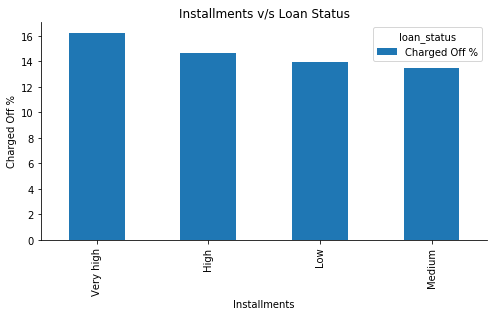

In [37]:
# Created 4 installment bins with 25% data in each
# Low        => [0, 165]
# Medium     => [166, 275]
# High       => [276, 420]
# Very High  => > 420
def createInstallmentBins(n):
    if n <= 165:
        return 'Low'
    elif n > 165 and n <=275:
        return 'Medium'
    elif n > 275 and n <=420:
        return 'High'
    else:
        return 'Very high'
    
loan_subset_df['installment_bin'] = loan_subset_df['installment'].apply(lambda x: createInstallmentBins(x))
showCategoricalPlots(loan_subset_df, 'installment_bin', 8, 'Installments')

# Inference :   If the burrower is taking the loan whose installment is higher ( > $420), 
#               there may be high chance of defaulting.

### 3.2.5 Segmenting loan_status by `loan amount`

loan_status    Charged Off  Fully Paid  Charged Off %
loan_amnt_bin                                        
Very high             1875        8583      17.928858
Low                   1353        8421      13.842848
High                  1238        7919      13.519712
Medium                1158        8025      12.610258


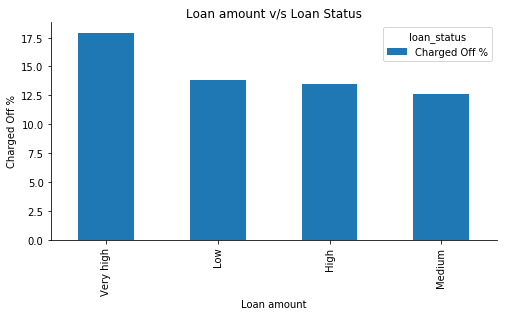

In [38]:
# Created 4 loan amount bins with 25% data in each
# Low        => [0, 5500)
# Medium     => [5500, 9600)
# High       => [9600, 15000)
# Very High  => > 15000
def createLoanAmountBins(n):
    if n < 5500:
        return 'Low'
    elif n >=5500 and n < 9600:
        return 'Medium'
    elif n >= 9600 and n < 15000:
        return 'High'
    else:
        return 'Very high'
    
loan_subset_df['loan_amnt_bin'] = loan_subset_df['loan_amnt'].apply(lambda x: createLoanAmountBins(x))
showCategoricalPlots(loan_subset_df, 'loan_amnt_bin', 8, 'Loan amount')

# Inference :   If the burrower is taking the loan whose loan amount is higher ( > $15000), 
#               there may be high chance of defaulting.

### 3.2.6 Segmenting loan_status by `annual income`

loan_status     Charged Off  Fully Paid  Charged Off %
annual_inc_bin                                        
Low                    1773        8093      17.970809
Medium                 1449        8177      15.052982
High                   1354        8341      13.965962
Very high              1048        8337      11.166755


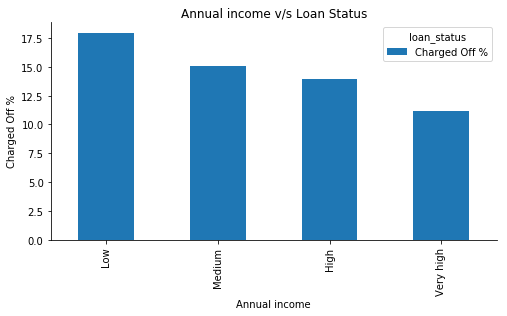

In [39]:
# Created 4 annual income bins with 25% data in each
# Low        => [0, 41000)
# Medium     => [41000, 60000)
# High       => [60000, 83500)
# Very High  => > 83500
def createAnnualIncomeBin(n):
    if n < 41000:
        return 'Low'
    elif n >= 41000 and n < 60000:
        return 'Medium'
    elif n >= 60000 and n < 83500:
        return 'High'
    else:
        return 'Very high'
    
loan_subset_df['annual_inc_bin'] = loan_subset_df['annual_inc'].apply(lambda x: createAnnualIncomeBin(x))
showCategoricalPlots(loan_subset_df, 'annual_inc_bin', 8, 'Annual income')

# Inference :   If the burrower is taking the loan whose annual income is lower ( < $41000), 
#               there may be high chance of defaulting.

### 3.2.7 Segmenting loan_status by ` dti`

loan_status  Charged Off  Fully Paid  Charged Off %
dti_bin                                            
Very high           1628        8112      16.714579
High                1521        8365      15.385393
Medium              1321        8214      13.854221
Low                 1154        8257      12.262246


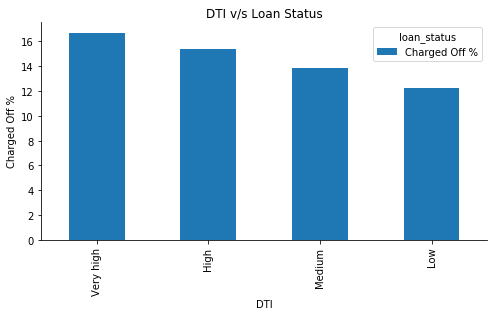

In [40]:
# Debt to income ratio
# Created 4 dti bins with 25% data in each
# Low        => [0, 8)
# Medium     => [8, 13.2)
# High       => [13.2, 18.5)
# Very High  => > 18.5
def createDTIBin(n):
    if n < 8:
        return 'Low'
    elif n >= 8 and n < 13.2:
        return 'Medium'
    elif n >= 13.2 and n < 18.5:
        return 'High'
    else:
        return 'Very high'
 
loan_subset_df['dti_bin'] = loan_subset_df['dti'].apply(lambda x: createDTIBin(x))
showCategoricalPlots(loan_subset_df, 'dti_bin', 8, 'DTI')

# Inference :   If the burrower is taking the loan whose dti is higher ( >= 18.5), 
#               there may be high chance of defaulting.

## Analysis Result :

- #### Based on the data analysis performed,`Recommendations` are:-
     1. Stop –  approving loans of lower grades `(G & F)`.
     2. Start – Charging higher interest rates for loans with DTI `(>=18)`. 
     3. More Verification required – Before approving  loan whose loan amount is higher `(> $15000)`. 
     4. Reduce – number of approvals where purpose  is `Small Business`.
     5. Stop – approving loans whose annual income is lower `(< $41,000)`.
